---
<div align="center">

# ML2 | Urban Sound Classification
</div>

---

---
## Problem Formulation
---

> ADD PROBLEM FORMULATION


For each of the chosen classifier, the implementation will need to consider the following steps:
1. Data pre-processing and preparation
2. Model architecture definition
3. Training strategies
4. Performance evaluation.

---
## Project Dependencies
---

In [1]:
# Remove ipykernel
# !jupyter kernelspec uninstall tf -y

In [2]:
# Add ipykernel
# !python -m ipykernel install --name "tensorflowKernel"

In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\gongas\anaconda3\envs\tensorflow\lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa as libr

from Utils.Configuration import (loadConfig)
from DataPreProcessing.AudioManagement import (loadAudio)
from DataPreProcessing.DataVisualization import (plotFeatureDistribution)

In [7]:
import sys
print(sys.executable)

C:\Users\Gongas\anaconda3\envs\Tensorflow\python.exe


In [8]:
# Load the Configuration Dictionary
config = loadConfig()

---
## Initial Data Assessment
---

> PLAY AROUND WITH THE DATA

In [9]:
# Load the dataset metadata
df = pd.read_csv('./UrbanSound8K/metadata/UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


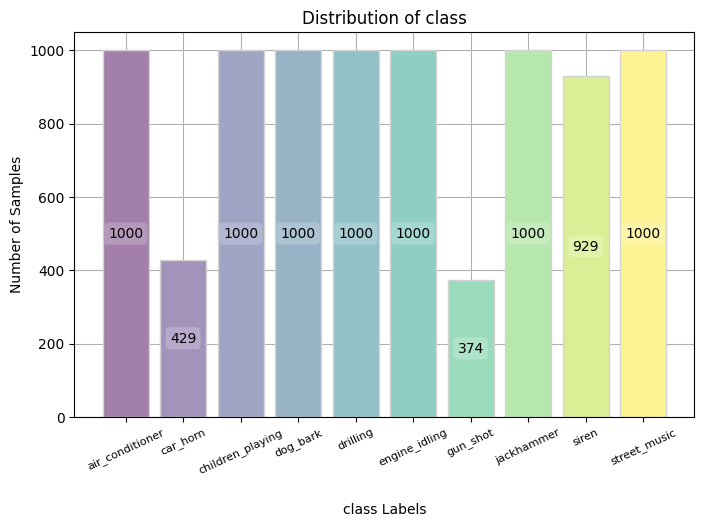

In [10]:
# Plot the distribution of the target class
plotFeatureDistribution(df, 'class')

In [11]:
# Load a random audio
# y, sr = loadAudio('100263-2-0-121.wav', df)
y, sr = loadAudio(audioSliceName='100263-2-0-137.wav', audioDuration=config['DURATION'], df_audio=df)
print(y)

[0.00125015 0.00428795 0.00624079 ... 0.00126011 0.00257258 0.00508059]


In [12]:
libr.feature.melspectrogram(y=y, sr=sr)
D = np.abs(libr.stft(y))**2
S = libr.feature.melspectrogram(S=D, sr=sr)

In [13]:
# Passing through arguments to the Mel filters
S = libr.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                    fmax=8000)

[Text(0.5, 1.0, 'MFCC')]

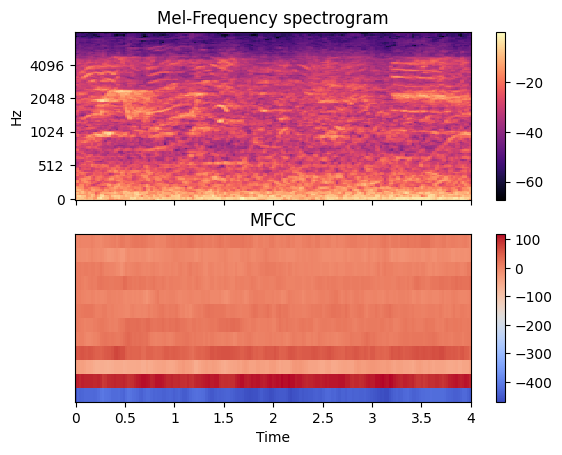

In [14]:
mfccs = libr.feature.mfcc(y=y, sr=sr, n_mfcc=12)
fig, ax = plt.subplots(nrows=2, sharex=True)
img = libr.display.specshow(libr.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel-Frequency spectrogram')
ax[0].label_outer()
img = libr.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')

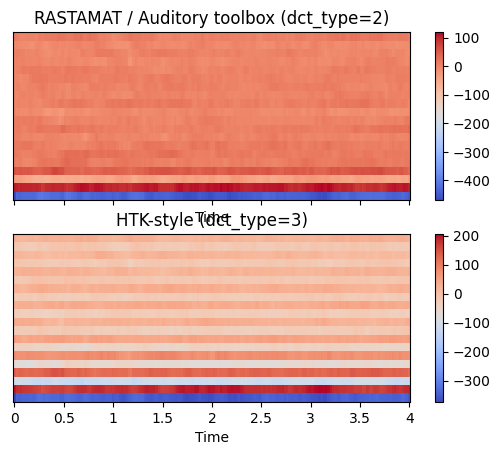

In [15]:
m_slaney = libr.feature.mfcc(y=y, sr=sr, dct_type=2)
m_htk = libr.feature.mfcc(y=y, sr=sr, dct_type=3)
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
img1 = libr.display.specshow(m_slaney, x_axis='time', ax=ax[0])
ax[0].set(title='RASTAMAT / Auditory toolbox (dct_type=2)')
fig.colorbar(img, ax=[ax[0]])
img2 = libr.display.specshow(m_htk, x_axis='time', ax=ax[1])
ax[1].set(title='HTK-style (dct_type=3)')
fig.colorbar(img2, ax=[ax[1]])

---
## Data Pre-Processing and Preparation
---

> PERFORM DATA PREPROCESSIGN AND PREPARATION

In [ ]:
# CODE HERE

---
## Model Architecture Definition
---

> ADD MODEL ARCHITECTURE DEFINITION

In [ ]:
# Load and preprocess the dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Build the model
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

In [ ]:
# CODE HERE

---
## Training Strategies
---

> ADD TRAINING STRATEGIES

In [ ]:
# CODE HERE

---
## Performance Evaluation
---
> ADD PERFORMANCE EVALUATION

In [ ]:
# CODE HERE

<div align="center">

***
## Bibliographic References
***
</div>

1. AUTHOR (DATE OF PUBLICATION). __*ARTICLE TITLE*__. Available [here](__INSERT_LINK__)

LINKS:
- https://medium.com/@MuhyEddin/feature-extraction-is-one-of-the-most-important-steps-in-developing-any-machine-learning-or-deep-94cf33a5dd46

---
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@edu.fc.up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@edu.fc.up.pt`
    - [Pedro Afonseca](https://github.com/PsuperX) &#8594; `up202205394@edu.fc.up.pt`